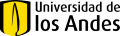

***
# **Microproyecto 1**

## Descripción del problema:

El problema a resolver consiste en generar nuevas secuencias de notas musicales basadas en el estilo de los artistas existentes, mencionados en la rúbrica del taller haciendo uso de archivos .mid como fuente de datos esto con el fin de entrenar un modelo que sea capaz de aprender de las diferentes características y posteriormente producir nuevas composiciones donde mantenga coherencia musical.

## Objetivo:

Con esta actividad se busca que el estudiante pueda poner en práctica el uso de modelos de redes neuronales para trabajar con datos secuenciales. Tras realizar esta actividad se espera que el estudiante esté en capacidad de:
1. Estructurar datos secuenciales de forma que pueden ser usados por modelos de redes neuronales.
2. Desarrollar soluciones de machine learning para datos secuenciales en distintos dominios.
3. Entrenar modelos de machine learning con múltiples salidas.
4. Entrenar modelos de machine learning con una función de costo compuesta.
5. Utilizar el modelo entrenado para generar nuevas secuencias.

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

***
# Índice

El *notebook* aborda el microproyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️.   | **Instalación e importe de librerías** |
| 1️.1️  | Importar librerías |
| 1️.2️. | Definición variables globales y funciones auxiliares|
| 1️.3️. | Definición de semillas |
| 2️.   | **Carga y procesamiento de los datos**  |
| 2️.1️. | Extracción características de los archivos .mid  |
| 2️.2️. | Estandarizar variables cuantitativas  |
| 2️.3️. | Generar secuencias de entrenamiento _requeridas para LSTM_  |
| 2️.4️. | Función Guardar secuencias a MIDI  |
| 3️. | **Desarrollo del modelo** |
| 3️.1️. | Dataset PyTorch  |
| 3️.2️. | Definición del modelo   |
| 4️. | **Etapa Entrenamiento**   |
| 4️.1️. | Funciones para entrenar   |
| 4️.2️. | Funciones para generar las nuevas notas musicales   |
| 5️. | **Definición de _main_**  |
| 6️. | **Conversión archivos .mid a .wav**   |
| 7️. | **Análisis de resultados y discusión**   |
| 8. | **Conclusión**   |
| 9. | **Referencias**   |

# 1. Instalación e importe de librerías

Versión usada de Python.

In [1]:
!python --version

Python 3.13.5


Para la ejecución de este Notebook, se recomienda realizar instalación de las librerías mencionadas a continuación:

In [2]:
#!pip install torch
#!pip install pretty_midi
#!pip install mido
#!pip install pyFluidSynth

## 1.1 Importar librerías

Diferente a las libras utilizadas a lo largo de la maestría, se destaca la importación de la librería **`psfluidsynth`** la cual nos va a permitir más adelante junto con el uso de lo que se conoce como *soundfont*, transformar los archivos desde el formato *.mid* a *.wav*. Para más información por favor revisar la bibliografía relacionada en este documento [¹].

In [3]:
# Importación de librerías del sistema
import sys, glob, os, time
import numpy as np
import random
import warnings
from importlib.metadata import version

# Gestión de archivos
from scipy.io.wavfile import write
from pathlib import Path

# Importación de librería de DL
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

# Dataloader
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Separación de datos
from sklearn.model_selection import train_test_split

# Librerías para MIDI y audio
import fluidsynth as pyfluidsynth
import pretty_midi

Se verifica versionamiento de las librerías para que pueda ser más fácil replicar este *notebook* más adelante.

In [27]:
# Ignorar las warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
librerias = ["numpy",
            "pandas",
            "scikit-learn",
            "matplotlib",
            "joblib",
            "torch",
            "tqdm",
            "pretty_midi"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  1.26.4
pandas :  2.3.2
scikit-learn :  1.7.2
matplotlib :  3.10.6
joblib :  1.5.1
torch :  2.10.0.dev20251012+cu130
tqdm :  4.67.1
pretty_midi :  0.2.11


## 1.2 Definición variables globales y funciones auxiliares
En esta sección se definen los parámetros clave utilizados más adelante para el desarrollo de *notebook*. Empezando por las carpetas de insumos y de salidas, las rutas de los *soundfont* que más adelante permitirán la conversión a *.wav*. Los parámetros de entrenamiento donde se destaca **`SEQ_LEN`**, el tamaño de las ventanas de contexto, **`BATCH_SIZE`** el tamaño de los sub-conjuntos de entrenamiento, **`PESO_LOSS_CONT`** que más adelante va a jugar un papel fundamental en el cálculo de la pérdida total, la cual está compuesta por una función de pérdida tipo **`MSE`** y otra tipo **`CROSS ENTROPY`**. 

También más adelante, se definen parámetros clave dentro de la arquitectura de la red neuronal utilizada, pero en la que ahondaremos más adelante. 

Este notebook en particular va a permitir, definir qué instrumento tomar para el entrenamiento y qué compositor elegir. En este caso se eligen los parámetros **`Acoustic Grand Piano`** y **`schubert`** de manera conveniente ya que esta elección permite obtener la mayor cantidad de notas para entrenar el modelo.

Cerramos esta sección con los parámetros que nos van a permitir generar las secuencias músicales. No hay mucho más que decir aquí además de que se usa la técnica de temperatura y una variación del "top K" aprendido en clase la cuál **no** se basa en percentiles de manera explícita, sino que el "K" refiere a la toma de cualquiera de las mejores K notas obtenidas para cada predicción [²]. Consideramos que al ser el rango de la predicción límite (discreto de 0 a 127 para los formato *.mid*) esta puede ser la palanca más correcta para poder "calibrar" el modelo.

In [5]:
#Rutas
ROOT_DIR =  "./Dataset/music_artist"
OUTPUT_DIR = Path("./OUTPUT")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Buscar soundfont disponible (multiplataforma)
def find_soundfont():
   
    # Posibles ubicaciones de soundfonts
    possible_soundfonts = ["./soundfonts/FluidR3_GM.sf2",  
        "/opt/homebrew/share/soundfonts/default.sf2", 
        "/opt/homebrew/share/soundfonts/FluidR3_GM.sf2",
        "/usr/local/share/soundfonts/default.sf2", 
        "/usr/local/share/soundfonts/FluidR3_GM.sf2",
        "/usr/share/soundfonts/default.sf2", 
        "/usr/share/soundfonts/FluidR3_GM.sf2",
        "/usr/share/sounds/sf2/FluidR3_GM.sf2",
        "/usr/share/sounds/sf2/default.sf2"]
    
    for sf2_path in possible_soundfonts:
        if os.path.exists(sf2_path):
            print(f"✓ Soundfont encontrado: {sf2_path}")
            return sf2_path
    
    # Si no se encuentra ninguno, dar instrucciones
    print(" No se encontró ningún archivo soundfont (.sf2)")
    print("\nInstrucciones para obtener un soundfont:")
    if sys.platform == "darwin":  # macOS
        print("  1. Descarga FluidR3_GM.sf2 desde: https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2")
        print("  2. Guárdar en: ./soundfonts/FluidR3_GM.sf2")
    elif sys.platform.startswith("linux"):  # Linux
        print("  Ubuntu/Debian: sudo apt-get install fluid-soundfont-gm")
        print("  O descarga desde: https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2")
    else:  # Windows
        print("  Descarga desde: https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2")
        print("  Guárdar en: .\\soundfonts\\FluidR3_GM.sf2")
    
    return None

SF2 = find_soundfont()

# Parámetros de lotes de entrenamiento
SEQ_LEN = 32 # Block size
BATCH_SIZE = 128
EPOCHS = 40
LR = 5e-4
PESO_LOSS_CONT = 20
PATIENCE = 8
MIN_DELTA = 1e-3

# Párametros redes
HIDDEN_SIZE = 320
NUM_LAYERS = 3
DROPOUT = 0.35
EMB_DIM = 96

# Elecciones usuario
MODEL_TYPE = "LSTM"  
INSTRUMENT_NAME = "Acoustic Grand Piano"
COMPOSER = "schubert"  # este es el artista que tiene más datos

# Parámetros de generación de secuencias
NUM_SEQS       = 3  # Número de secuencias a generar
STEPS_PER_SEQ  = 200  # Notas que debe tener cada secuencia
TEMPERATURE    = 0.65  # Temperatura
TOP_K = 20  # Metodología para delimitar el dominio de notas a elegir

✓ Soundfont encontrado: ./soundfonts/FluidR3_GM.sf2


In [28]:
# Esta función permite informar cuánto tiempo tarda en correr cada modelo. Propósito: solo informativo para referencia al momento de ejecutar el Notebook.
def print_time_execution(inicio, fin):
    str_log = ""
    duracion = fin - inicio
    if duracion > 60:
        minutos = duracion // 60
        segundos = duracion % 60
        str_log = f"Tiempo: {minutos:.0f} minutos y {segundos:.2f} segundos"
    else:
        str_log = f"Tiempo: {duracion:.2f} segundos"
    print(str_log)

## 1.3 Definición de semillas

Aseguramos reproducibilidad:

In [29]:
# Semilla pseudo-aleatoria usada
RANDOM_STATE = 13
random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE); torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
# Detección y validación del dispositivo
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✓ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"  - Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  - CUDA version: {torch.version.cuda}")
else:
    DEVICE = torch.device("cpu")
    print(" GPU no disponible, usando CPU")
    print(" - Nota: El entrenamiento será más lento en CPU")

print(f"  - Dispositivo seleccionado: {DEVICE}")
DEVICE

✓ GPU disponible: NVIDIA GeForce RTX 5070
  - Memoria total: 12.82 GB
  - CUDA version: 13.0
  - Dispositivo seleccionado: cuda


device(type='cuda')

# 2. Carga y procesamiento de los datos.

## 2.1. Extracción características de los archivos .mid

En esta sección se realiza la selección del primer instrumento encontrado y extracción notas del instrumento seleccionado. Como resultado se extraen las siguientes características por cada nota leída:   
- *Pitch*: representa la nota musical.
- *Step*: es el espacio de tiempo que hay entre la nota anterior y la nota actual.
- *Duration*: Es la diferencia de tiempo en el que termina la nota actual (end) menos el inicio de la nota (start).
- *Velocity*: es la velocidad de la nota musical.

In [9]:
inicio = time.time()

In [30]:
# Extracción de notas crudas sin procesar por dataloader
def extract_raw_note_sequences(root_dir, instrument_name=None, program_number=None, composer_name=None):
    raw_sequences = []
    candidates = [composer_name] if composer_name else [ d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for composer in candidates:
        folder = os.path.join(root_dir, composer)
        midi_files = glob.glob(os.path.join(folder, "*.mid"))

        for mf in midi_files:
            try:
                pm = pretty_midi.PrettyMIDI(mf)
            except Exception as e:
                print(f"No se pudo leer {mf}: {e}")
                continue

            # Selección instrumento
            chosen_instruments = []
            for i, inst in enumerate(pm.instruments):
                name = pretty_midi.program_to_instrument_name(inst.program)
                print(f"[{i}] prog={inst.program:>2} name={name} notas={len(inst.notes)}")
                if instrument_name is not None:
                    inst_name = pretty_midi.program_to_instrument_name(inst.program)
                    if inst_name.lower() == instrument_name.lower():
                        chosen_instruments.append(inst)
                elif program_number is not None:
                    if inst.program == program_number:
                        chosen_instruments.append(inst)

            # Si no hubo match explícito y no se especificó filtro, tomamos el primero
            if instrument_name is None and program_number is None:
                chosen_instruments = pm.instruments[:1]  

            if not chosen_instruments:
                # Nada que extraer en este archivo para el instrumento pedido
                continue

            # Extraer notas SOLO del/los instrumentos elegidos 
            notes = []
            for inst in chosen_instruments:
                for note_mus in inst.notes:
                    start = note_mus.start
                    end = note_mus.end
                    duration = end - start
                    velocity = note_mus.velocity
                    notes.append((start, note_mus.pitch, duration, velocity))

            if not notes:
                continue

            # Ordenar por inicio y construir [pitch, step, duration, velocity]
            notes.sort(key=lambda x: x[0])
            note_feats = []
            prev_start = notes[0][0]
            for start, pitch, duration, velocity in notes:
                step = start - prev_start
                prev_start = start
                note_feats.append([pitch, step, duration, velocity])

            if note_feats:
                raw_sequences.append(np.array(note_feats, dtype=np.float32))

    return raw_sequences

## 2.2. Estandarizar variables cuantitativas

Este paso es necesario dado que los modelos de red neuronal son muy sensibles a las escalas de los datos. Al no estandarizar las variables continuas (*step*, *duration* y *velocity*), el modelo no aprenderá correctamente las relaciones entre variables.

La presente estandarización lleva todas las variables continuas a extraer el promedio y la desviación estandar normalizando cada valor individual, siguiendo la fórmula del *Z-score*:
**$norm_x = (x - mean) / std$**. 

In [11]:
# Estandariza las variables continuas (step, duration, velocity)
def standardize_note_sequences(sequences):
    all_steps, all_durations, all_velocities = [], [], []

    # Recolectar todas las variables continuas para calcular media y std global
    for seq in sequences:
        all_steps.extend(seq[:, 1])
        all_durations.extend(seq[:, 2])
        all_velocities.extend(seq[:, 3])

    # Estadísticas globales
    step_mean, step_std = np.mean(all_steps), np.std(all_steps)
    dur_mean, dur_std = np.mean(all_durations), np.std(all_durations)
    vel_mean, vel_std = np.mean(all_velocities), np.std(all_velocities)

    standardized = []
    for seq in sequences:
        seq_std = seq.copy()
        # No tocar pitch (columna 0)
        seq_std[:, 1] = (seq[:, 1] - step_mean) / (step_std + 1e-6)
        seq_std[:, 2] = (seq[:, 2] - dur_mean) / (dur_std + 1e-6)
        seq_std[:, 3] = (seq[:, 3] - vel_mean) / (vel_std + 1e-6)
        standardized.append(seq_std)

    stats = {"step_mean": step_mean, "step_std": step_std,
            "dur_mean": dur_mean, "dur_std": dur_std,
            "vel_mean": vel_mean, "vel_std": vel_std}

    return standardized, stats

## 2.3. Generar secuencias de entrenamiento

Esta sección realiza la conversión de una secuencia larga de notas en muestras pequeñas de longitud fija llamadas ventanas de contexto o secuencias de entrenamiento. La entrada de datos debe tener estandarizadas las variables continuas.

In [12]:
# Crea pares (X, y) con ventanas de contexto para entrenamiento a partir de las secuencias estandarizadas.
def create_windows(sequences, seq_len=32):

    X_pitch, X_cont, y_pitch, y_cont = [], [], [], []

    for seq in sequences:
        if len(seq) < seq_len + 1:
            continue

        # Dividir en ventanas
        for i in range(len(seq) - seq_len):
            window = seq[i:i+seq_len]
            target = seq[i+seq_len]

            # Separar pitch (entero) y las features continuas
            X_pitch.append(window[:, 0].astype(np.int64))     # pitch
            X_cont.append(window[:, 1:].astype(np.float32))   # step, duration, velocity
            y_pitch.append(int(target[0]))                    # pitch de la siguiente nota
            y_cont.append(target[1:].astype(np.float32))      # step, duration, velocity siguientes

    # Convertir a arrays numpy
    X_pitch = np.array(X_pitch, dtype=np.int64)
    X_cont = np.array(X_cont, dtype=np.float32)
    y_pitch = np.array(y_pitch, dtype=np.int64)
    y_cont = np.array(y_cont, dtype=np.float32)

    return (X_pitch, X_cont), (y_pitch, y_cont)

## 2.4. Función Guardar secuencias a MIDI

Las funciones **`save_sequence_to_midi`** y **`save_std_sequence_to_midi`** permiten tomar las secuencias (estandarizadas o no estandarizadas) y generar de nuevo el archivo *.mid* con el fin de validar que no se hayan corrompido las notas musicales.

In [13]:
# Guardado de secuencias a .mid con insumo sin estandarizar
def save_sequence_to_midi(seq, output_path="generated.mid", instrument_name="Acoustic Grand Piano"):

    pm = pretty_midi.PrettyMIDI()
    #Obtención del instrumento
    try:
        program_number = pretty_midi.instrument_name_to_program(instrument_name)
    except ValueError:
        program_number = 0
    instrument = pretty_midi.Instrument(program=program_number)

    # Asegurar valores válidos
    pitch    = seq[:, 0].astype(int)
    step     = np.maximum(seq[:, 1].astype(float), 0.0)
    duration = np.maximum(seq[:, 2].astype(float), 0.01)
    velocity = np.clip(seq[:, 3].astype(float), 0, 127).astype(int)

    # Reconstruir tiempos absolutos
    t = 0.0
    for p, s, d, v in zip(pitch, step, duration, velocity):
        t += s
        note = pretty_midi.Note(velocity=int(v), pitch=int(p), start=float(t), end=float(t + d))
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(output_path)
    print(f"MIDI guardado en: {output_path} ({instrument_name})")

In [14]:
# Guardado de secuencias a .mid con insumo estandarizado
def save_std_sequence_to_midi(seq_std, stats, output_path="reconstructed.mid", instrument_name="Acoustic Grand Piano"):

    # Desestandarizar
    pitch    = seq_std[:, 0]
    step     = seq_std[:, 1] * stats["step_std"] + stats["step_mean"]
    duration = seq_std[:, 2] * stats["dur_std"] + stats["dur_mean"]
    velocity = seq_std[:, 3] * stats["vel_std"] + stats["vel_mean"]
    seq_real = np.stack([pitch, step, duration, velocity], axis=1)
    # Reutilizar la canónica
    save_sequence_to_midi(seq_real, output_path=output_path, instrument_name=instrument_name)

# 3. Desarrollo del modelo

## 3.1. Dataset PyTorch

Preparamos los datos musicales usando la clase **`MusicWindowsDataset`** para llevar nuestro *dataset* a un formato *tensor* - *long* / *float32*  para que el modelo en **`torch`** pueda consumirlo.

In [15]:
class MusicWindowsDataset(Dataset):
    """
    Dataset personalizado para las ventanas de música.
    Proporciona pares ((Xp, Xc), (yp, yc)) donde:
    - Xp: secuencia de pitches (enteros)
    - Xc: secuencia de características continuas (step, duration, velocity)
    - yp: pitch objetivo (entero)
    - yc: características continuas objetivo (step, duration, velocity)
    """
    def __init__(self, Xp, Xc, yp, yc):
        self.Xp = Xp
        self.Xc = Xc
        self.yp = yp
        self.yc = yc

    def __len__(self):
        return len(self.Xp)

    def __getitem__(self, i):
        import torch
        Xp = torch.as_tensor(self.Xp[i], dtype=torch.long)        # [L]
        Xc = torch.as_tensor(self.Xc[i], dtype=torch.float32)     # [L,3]
        yp = torch.as_tensor(self.yp[i], dtype=torch.long)        # []
        yc = torch.as_tensor(self.yc[i], dtype=torch.float32)     # [3]
        return (Xp, Xc), (yp, yc)  

## 3.2 Definición del modelo

Consideramos que en escencia el modelo que mejor puede captura la información respecto a las secuencias musicales es el conocido **`LSTM`**. Sus memorias de corto y largo plazo, pueden capturar relaciones entre sus notas las cuales pueden ser ciclicas-corto placistas pero también, estas memorias, permiten conservar la estructura "como un todo" de la secuencia musical, haciendo que tenga sentido y armonía. Los detalles de la arquitectura se muestran más adelante en el diagrama, pero en escencia el modelo usado gira alrededor de la metodología **`LSTM`**.

In [16]:
#  Modelo LSTM para predecir la siguiente nota y sus características continuas.
class MusicLSTM(nn.Module):

    def __init__(self, vocab_size, emb_dim=64, cont_dim=3, hidden_size=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=None)
        self.emb_drop = nn.Dropout(0.15)
        self.input_dim = emb_dim + cont_dim
        self.lstm = nn.LSTM(self.input_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.ln = nn.LayerNorm(hidden_size)  # Capa de normalización
        self.pitch_out = nn.Linear(hidden_size, vocab_size)
        self.cont_out  = nn.Linear(hidden_size, cont_dim)

    def forward(self, pitch_seq, cont_seq):

        emb = self.emb(pitch_seq)                # (B, seq_len, emb_dim)
        x = torch.cat([emb, cont_seq], dim=-1)   # (B, seq_len, emb+cont)
        out, (h, c) = self.lstm(x)               # out: (B, seq_len, hidden)
        last = out[:, -1, :]
        last = self.ln(last)
        pitch_logits = self.pitch_out(last)
        cont_pred    = self.cont_out(last)
        return pitch_logits, cont_pred

## 3.3 Diagrama de arquitectura

El modelo **MusicLSTM** recibe dos entradas: una secuencia discreta de *pitches* (notas MIDI codificadas entre 0 y 127) y tres características continuas por timestep (*step*, *duration* y *velocity*).  
Primero, las notas pasan por una capa de *embedding* de 96 dimensiones, que aprende representaciones densas de las notas musicales. Estas se fusionan con las variables continuas para formar vectores de 99 features por paso temporal.

A continuación, una LSTM apilada de tres capas o las que se designen por parámetro (**`hidden size`** = 320, **`dropout`**= 0.35) captura las dependencias temporales y la estructura secuencial de la música. Del último *hidden state* se obtiene un **vector de contexto** de 320 dimensiones, que luego se normaliza mediante *layer Normalization* para estabilizar el entrenamiento.

Finalmente, el modelo se divide en dos cabezas de salida:  
- una de **clasificación** (Linear 320 → 128) que predice la siguiente nota MIDI,  
- y otra de **regresión** (Linear 320 → 3) que estima los valores continuos de *step*, *duration* y *velocity*.

Este diseño permite generar melodías donde se combinan eventos discretos (*pitches*) y propiedades temporales continuas, manteniendo coherencia rítmica y expresiva.

In [31]:
from IPython.display import IFrame

# Ruta del PDF
IFrame("./Arquitectura MusicLSTM.pdf", width=800, height=500)

# 4. Etapa Entrenamiento

## 4.1. Funciones para entrenar

La clase `EarlyStopping` es una técnica de regularización usada durante el entrenamiento para evitar el sobreajuste esto con el fin de evitar que memorice los datos de entrenamiento.

In [17]:
class EarlyStopping:
    """
    Early stopping basado en una métrica escalar (modo 'min').
    Guarda el mejor valor observado y cuenta épocas sin mejora.
    """
    def __init__(self, patience=6, min_delta=0.0):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.best = None
        self.bad_epochs = 0

    def step(self, value: float) -> bool:
        """
        Devuelve True si hubo mejora y debe guardarse checkpoint.
        """
        if self.best is None or (value < self.best - self.min_delta):
            self.best = float(value)
            self.bad_epochs = 0
            return True
        else:
            self.bad_epochs += 1
            return False

    def should_stop(self) -> bool:
        return self.bad_epochs >= self.patience

La función `train` realiza el entrenamiento completo del modelo con las siguientes características:

**Parámetros principales:**
- `model`: Modelo de red neuronal (LSTM/RNN/GRU) a entrenar
- `train_loader`: DataLoader con los datos de entrenamiento
- `val_loader`: DataLoader con los datos de validación
- `device`: Dispositivo donde se ejecutará el entrenamiento (CPU o GPU)
- `epochs`: Número máximo de épocas de entrenamiento
- `lr`: Tasa de aprendizaje (learning rate) para el optimizador AdamW

**Función de pérdida compuesta:**
- `CrossEntropyLoss` con label smoothing (0.05) para predecir el pitch (variable categórica)
- `Smooth L1 Loss` (Huber Loss) para predecir las variables continuas (step, duration, velocity)
- `cont_loss_weight`: Factor que pondera la importancia de las variables continuas en la pérdida total

**Early Stopping:**
- `es_patience`: Número de épocas sin mejora antes de detener el entrenamiento
- `es_min_delta`: Mejora mínima requerida para considerar que hubo progreso
- `best_ckpt_path`: Ruta donde se guardará el mejor modelo encontrado

**Técnicas de regularización aplicadas:**
- Gradient clipping (norm máxima de 1.0) para evitar gradientes explosivos
- Label smoothing en la pérdida de clasificación
- Dropout en las capas recurrentes del modelo

**Retorna:**
- `history`: Diccionario con las métricas de entrenamiento y validación por época, incluyendo la mejor época encontrada

In [18]:
def train(model, train_loader, val_loader, device, epochs=40,
          lr=5e-4, cont_loss_weight=50.0,
          # parámetros de early stopping
          es_patience=6,
          es_min_delta=0.0,
          best_ckpt_path="OUTPUT/best_music_lstm.pth",
          verbose=True):

    """ 
    Entrena el modelo con los datos de train_loader y val_loader.
    Usa AdamW, CrossEntropy para pitch y MSE para continuos.
    Guarda el mejor modelo según la métrica val_total = val_CE + cont_loss_weight
    history: diccionario con métricas de entrenamiento y validación.
    """


    model.to(device)
    opt = AdamW(model.parameters(), lr=lr)

    history = { "train_loss": [],
                "val_CE": [],
                "val_MSE": [],
                "val_total": [],
                "best_epoch": None,
                "best_val_total": None,
                "best_ckpt_path": best_ckpt_path}

    # Inicializa EarlyStopping
    es = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
    # Usar tqdm para mostrar progreso general
    epoch_iterator = range(1, epochs + 1)
    
    for epoch in epoch_iterator:
        # Entrenamiento
        model.train()
        running = 0.0
        # Barra de progreso para batches de entrenamiento (una barra horizontal por época que permanece)
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch:>3}/{epochs} [Train]", leave=True, ncols=100) if verbose else train_loader
        
        for (Xp, Xc), (yp, yc) in train_iter:
            Xp = Xp.to(device)           
            Xc = Xc.to(device)           
            yp = yp.to(device)           
            yc = yc.to(device)         

            opt.zero_grad(set_to_none=True)
            logits, cont_pred = model(Xp, Xc)         # logits [B,L,V]; cont_pred [B,L,3]
            # Usa directamente la salida del modelo
            logits_last = logits               # (B, V)
            cont_last   = cont_pred            # (B, 3)

            ce  = F.cross_entropy(logits_last, yp, label_smoothing=0.05)    # CE para pitch
            mse = F.smooth_l1_loss(cont_last, yc, beta=0.5)    #F.mse_loss(cont_last, yc)          # MSE para continuos (normalizados)
            loss = ce + cont_loss_weight * mse

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += loss.item()
            
            # Actualizar descripción de la barra
            if verbose and hasattr(train_iter, 'set_postfix'):
                train_iter.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running / max(1, len(train_loader))

        # Validación
        model.eval()
        val_ce = 0.0
        val_mse = 0.0
        with torch.no_grad():
            # Barra de progreso para validación (opcional, más compacta)
            val_iter = tqdm(val_loader, desc=f"Epoch {epoch:>3}/{epochs} [Val]  ", leave=True, ncols=100) if verbose else val_loader
            for (Xp, Xc), (yp, yc) in val_iter:
                Xp = Xp.to(device)
                Xc = Xc.to(device)
                yp = yp.to(device)
                yc = yc.to(device)

                logits, cont_pred = model(Xp, Xc)
                logits_last = logits          # (B, V)
                cont_last   = cont_pred       # (B, 3)

                ce  = F.cross_entropy(logits_last, yp, label_smoothing=0.05)
                mse = F.mse_loss(cont_last, yc)
                val_ce  += ce.item()
                val_mse += mse.item()

        val_ce  /= max(1, len(val_loader))
        val_mse /= max(1, len(val_loader))
       
        val_total = val_ce + cont_loss_weight * val_mse

        history["train_loss"].append(train_loss)
        history["val_CE"].append(val_ce)
        history["val_MSE"].append(val_mse)
        history["val_total"].append(val_total)

        # Actualizar barra de progreso principal con métricas
        if verbose and hasattr(epoch_iterator, 'set_postfix'):
            epoch_iterator.set_postfix({
                'train_loss': f'{train_loss:.4f}',
                'val_total': f'{val_total:.4f}',
                'best': f'{history["best_val_total"]:.4f}' if history["best_val_total"] else 'N/A'
            })

        if verbose and not hasattr(epoch_iterator, 'set_postfix'):
            print(f"Epoch {epoch} | train_loss={train_loss:.4f} | "
                  f"val_CE={val_ce:.4f} | val_MSE={val_mse:.5f} | "
                  f"val_total={val_total:.4f}")

        # Checkpoint si mejora
        if es.step(val_total):
            torch.save({"model_state": model.state_dict()}, best_ckpt_path)
            history["best_epoch"] = epoch
            history["best_val_total"] = val_total
            if verbose:
                print(f"  ↳ ✓ Nuevo mejor modelo guardado en {best_ckpt_path}")

        # Parar si no mejora por 'patience'
        if es.should_stop():
            if verbose:
                print(f"  ↳ Early stopping en epoch {epoch} (best_epoch={history['best_epoch']})")
            break

    return history

## 4.2. Funciones para generar las nuevas notas musicales.

`sample_from_logits_topk` elige la siguiente nota de forma probabilistica usando las salidas (logits) del modelo.
La salida del modelo entrega una distribucion de probabilidades sobre todas las posibles notas.

In [19]:
def sample_from_logits_topk(logits, k=10, temperature=1.0):
    """
    logits: torch.Tensor [vocab] o numpy.ndarray [vocab]
    k: número de top-k a considerar
    temperature: float > 0, controla la aleatoriedad del muestreo
    (temperature -> 0: más determinista, temperature -> ∞: más aleatorio)
    Retorna:
    Índice entero muestreado en top-k (con temperatura).
    Si logits es numpy.ndarray, se convierte a torch.Tensor.
    """
    import torch
    if not isinstance(logits, torch.Tensor):
        logits = torch.from_numpy(logits)

    # Evita k inválido
    vocab = logits.shape[-1]
    k = max(1, min(int(k), int(vocab)))

    # Último paso de la secuencia si viene con eje extra
    # (p.ej., [1, V] -> [V])
    if logits.ndim > 1:
        logits = logits.view(-1)

    # Temperatura
    if temperature is None or temperature <= 0:
        temperature = 1.0
    logits = logits / float(temperature)

    # Top-k + muestreo
    topk_vals, topk_idx = torch.topk(logits, k)          
    topk_probs = torch.softmax(topk_vals, dim=-1)        
    choice = torch.multinomial(topk_probs, 1)            
    return int(topk_idx[choice].item())

La función `generate_sequence` genera nuevas secuencias musicales de forma autoregresiva paso a paso.

**Proceso de generación:**

1. **Inicialización**: Toma una secuencia inicial (seed) como punto de partida que contiene:
   - `seed_pitch_seq`: Secuencia de pitches (notas musicales) como enteros
   - `seed_cont_seq`: Características continuas normalizadas (step, duration, velocity)

2. **Generación iterativa**: En cada paso:
   - El modelo recibe los últimos `max_context` (32) elementos de la secuencia
   - Predice la siguiente nota con sus características continuas
   - La predicción se añade al contexto para la siguiente iteración

3. **Muestreo controlado**:
   - **Top-k sampling**: Solo considera las k notas más probables (parámetro `top_k`)
   - **Temperature**: Controla la aleatoriedad del muestreo:
     - Valores bajos (< 1.0): Más conservador, sigue patrones aprendidos
     - Valores altos (> 1.0): Más creativo, genera variaciones inesperadas
     - Valor de 1.0: Muestreo directo de la distribución

4. **Desnormalización**: Las características continuas predichas se convierten de vuelta a su escala original usando las estadísticas guardadas durante el entrenamiento (`stats`).

5. **Validación**: Se asegura que todos los valores generados sean válidos:
   - Pitch: entre 0 y 127 (rango MIDI estándar)
   - Step: no negativo
   - Duration: mínimo 1 ms
   - Velocity: entre 1 y 127

**Retorna:**
- Array numpy de forma [steps, 4] con columnas [pitch, step, duration, velocity] en escala real, listo para convertir a archivo MIDI

In [20]:
@torch.no_grad()
def generate_sequence(model, device, seed_pitch_seq, seed_cont_seq, steps=200, 
                      idx2pitch=None, stats=None, temperature=1.0, top_k=10,
                      max_context=32):
    """
    Toma el modelo entrenado y una secuencia inicial (seed) de notas
    (pitch_seq: np.ndarray [T_seed] de enteros; cont_seq: np
    .ndarray [T_seed, 3] de continuos normalizados)
    
    Genera una secuencia de notas a partir de una secuencia inicial.
    Devuelve: np.ndarray shape [T_gen, 4] con columnas [pitch, step, dur, vel]
    """
    model.eval()

    # Normalización defensiva de entradas
    seed_pitch_seq = np.asarray(seed_pitch_seq, dtype=np.int64)          
    seed_cont_seq  = np.asarray(seed_cont_seq,  dtype=np.float32)        
    assert seed_cont_seq.ndim == 2 and seed_cont_seq.shape[1] == 3, "seed_cont_seq debe ser [T,3]"

    # Construir tensores en el dispositivo sin listas de ndarrays:
    def _mk_inputs(pitches_np, cont_np):
        # recorta al contexto
        pitches_np = pitches_np[-max_context:]
        cont_np    = cont_np[-max_context:]
        inp_pitch = torch.as_tensor(pitches_np, dtype=torch.long, device=device).unsqueeze(0)   # [1, L]
        inp_cont  = torch.as_tensor(cont_np,    dtype=torch.float32, device=device).unsqueeze(0) # [1, L, 3]
        return inp_pitch, inp_cont

    # Copias de trabajo (para ir anexando)
    cur_pitch = seed_pitch_seq.copy()
    cur_cont  = seed_cont_seq.copy()

    generated_rows = []  # acumularemos filas [pitch, step, dur, vel] 

    for _ in range(steps):
        inp_pitch, inp_cont = _mk_inputs(cur_pitch, cur_cont)
        logits, cont_pred = model(inp_pitch, inp_cont)  

        # Tomar el último paso temporal
        logits_last = logits.squeeze(0)                
        cont_last   = cont_pred.squeeze(0).cpu().numpy() # (3,)  

        # Muestreo discreto
        next_pitch_idx = sample_from_logits_topk(logits_last, k=top_k, temperature=temperature)

        # Desnormalizar los 3 continuos 
        if stats is not None:
            step = (cont_last[0] * (float(stats["step_std"]) + 1e-6)) + float(stats["step_mean"])
            dur  = (cont_last[1] * (float(stats["dur_std"])  + 1e-6)) + float(stats["dur_mean"])
            vel  = (cont_last[2] * (float(stats["vel_std"])  + 1e-6)) + float(stats["vel_mean"])
        else:
            step, dur, vel = float(cont_last[0]), float(cont_last[1]), float(cont_last[2])

        # Seguridad: valores válidos
        next_pitch = int(np.clip(next_pitch_idx, 0, 127))
        step = max(0.0, float(step))
        dur  = max(1e-3, float(dur))
        vel  = float(np.clip(vel, 1.0, 127.0))

        # Append a las listas de estado (en formato NORMALIZADO para el modelo)
        # Nota: para la siguiente iteración el modelo necesita los continuos NORMALIZADOS,
        # por lo que guardamos además la versión normalizada:
        if stats is not None:
            step_n = (step - float(stats["step_mean"])) / (float(stats["step_std"]) + 1e-6)
            dur_n  = (dur  - float(stats["dur_mean"]))  / (float(stats["dur_std"])  + 1e-6)
            vel_n  = (vel  - float(stats["vel_mean"]))  / (float(stats["vel_std"])  + 1e-6)
            cur_cont = np.vstack([cur_cont, [step_n, dur_n, vel_n]]).astype(np.float32)
        else:
            cur_cont = np.vstack([cur_cont, [step, dur, vel]]).astype(np.float32)

        cur_pitch = np.append(cur_pitch, next_pitch).astype(np.int64)

        # Guardar fila desnormalizada para el MIDI
        generated_rows.append([next_pitch, step, dur, vel])

    return np.asarray(generated_rows, dtype=np.float32)

# 5. Definición de _main_

In [21]:
if __name__ == "__main__":
    print("1. Extrayendo secuencias crudas...")
    raw_sequences = extract_raw_note_sequences(ROOT_DIR, instrument_name= INSTRUMENT_NAME, composer_name=COMPOSER)
    print(f"  secuencias extraídas: {len(raw_sequences)}")

    train_sequences, val_sequences = train_test_split(raw_sequences, test_size=0.2, random_state=RANDOM_STATE)

    print("2. Estandarizando variables continuas ...")
    standardized_sequences, stats = standardize_note_sequences(train_sequences)
    print("  stats:", stats)

    def apply_standardization(seqs, stats):
        out = []
        for seq in seqs:
            s = seq.copy()
            s[:,1] = (s[:,1]-stats["step_mean"])/(stats["step_std"]+1e-6)
            s[:,2] = (s[:,2]-stats["dur_mean"] )/(stats["dur_std"] +1e-6)
            s[:,3] = (s[:,3]-stats["vel_mean"] )/(stats["vel_std"] +1e-6)
            out.append(s)
        return out

    val_standardized = apply_standardization(val_sequences, stats)

    print("3. Creando ventanas...")
    (Xp_tr, Xc_tr), (yp_tr, yc_tr) = create_windows(standardized_sequences, seq_len=SEQ_LEN)
    (Xp_va, Xc_va), (yp_va, yc_va) = create_windows(val_standardized,       seq_len=SEQ_LEN)

    print("  Train -> Xp_tr:", Xp_tr.shape, "Xc_tr:", Xc_tr.shape, "yp_tr:", yp_tr.shape)
    print("  Valid -> Xp_va:", Xp_va.shape, "Xc_va:", Xc_va.shape, "yp_va:", yp_va.shape)


    # construir vocab (opcional
    if Xp_tr.shape[0] == 0:
        raise RuntimeError("No hay muestras. Aumenta datos o reduce SEQ_LEN.")
    max_pitch = int(np.max(Xp_tr))
    vocab_size = max(128, max_pitch + 1)
    print("vocab_size:", vocab_size)

    # Dataset de PyTorch
    print("4. Preparando DataLoaders...")
    train_ds = MusicWindowsDataset(Xp_tr, Xc_tr, yp_tr, yc_tr)
    val_ds   = MusicWindowsDataset(Xp_va,   Xc_va,   yp_va,   yc_va)
    loader   = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    vloader  = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # Modelo y entrenamiento
    print("5. Construyendo y entrenando el modelo...")
    model = MusicLSTM(vocab_size=vocab_size, emb_dim=EMB_DIM, cont_dim=3, hidden_size= HIDDEN_SIZE, num_layers= NUM_LAYERS,dropout=DROPOUT) # Ajustado num_layers
    print("   Training model on device:", DEVICE)
    history = train(
        model,
        train_loader=loader,
        val_loader=vloader,
        device=DEVICE,
        epochs=EPOCHS,
        lr=LR,
        cont_loss_weight= PESO_LOSS_CONT,
        es_patience= PATIENCE,                
        es_min_delta= MIN_DELTA,           
        best_ckpt_path=(OUTPUT_DIR / "best_music_lstm.pth").as_posix(),
    )

    # Guardar modelo y stats
    # Cargar mejor estado antes de generar
    best_ckpt = torch.load((OUTPUT_DIR / "best_music_lstm.pth").as_posix(), map_location=DEVICE)
    model.load_state_dict(best_ckpt["model_state"])
    model.to(DEVICE)
    model.eval()

    #  Generación de ejemplos
    print("6. Generando ejemplos...")
    total_samples = Xp_tr.shape[0]
   
    # Elegimos índices de semillas distintos si hay suficientes, o con reposición si no
    idx_pool = list(range(total_samples))
    if total_samples >= NUM_SEQS:
        seed_indices = random.sample(idx_pool, NUM_SEQS)  # sin reemplazo
    else:
        seed_indices = [random.choice(idx_pool) for _ in range(NUM_SEQS)]  # con reemplazo
    
    for j, idx in enumerate(seed_indices, start=1):
        seed_pitch = Xp_tr[idx].tolist()
        seed_cont  = Xc_tr[idx]
        print(f"[Gen {j}] Usando semilla index: {idx}")
    
        generated = generate_sequence(
            model, DEVICE,
            seed_pitch, seed_cont,
            steps=STEPS_PER_SEQ,
            idx2pitch=None,
            stats=stats,
            temperature=TEMPERATURE,
            top_k=TOP_K)
        
        if generated.shape[0] > 200:
          generated = generated[-200:, :]

        # TODO: Alerta / diagrama / histograma de distribución
        midi_path = OUTPUT_DIR / f"generated_music_lstm_{j}.mid"
        save_sequence_to_midi(generated, output_path=midi_path.as_posix(), instrument_name=INSTRUMENT_NAME)
        print(f"[Gen {j}] MIDI guardado en: {midi_path}")

1. Extrayendo secuencias crudas...
[0] prog= 0 name=Acoustic Grand Piano notas=4225
[1] prog= 0 name=Acoustic Grand Piano notas=3300
[0] prog= 0 name=Acoustic Grand Piano notas=2954
[1] prog= 0 name=Acoustic Grand Piano notas=2173
[0] prog= 0 name=Acoustic Grand Piano notas=3868
[1] prog= 0 name=Acoustic Grand Piano notas=2580
[0] prog= 0 name=Acoustic Grand Piano notas=3185
[1] prog= 0 name=Acoustic Grand Piano notas=2792
[0] prog= 0 name=Acoustic Grand Piano notas=2854
[1] prog= 0 name=Acoustic Grand Piano notas=3395
[0] prog= 0 name=Acoustic Grand Piano notas=1850
[1] prog= 0 name=Acoustic Grand Piano notas=885
[0] prog= 0 name=Acoustic Grand Piano notas=3239
[1] prog= 0 name=Acoustic Grand Piano notas=3186
[0] prog= 0 name=Acoustic Grand Piano notas=2970
[1] prog= 0 name=Acoustic Grand Piano notas=1822
[0] prog= 0 name=Acoustic Grand Piano notas=2592
[1] prog= 0 name=Acoustic Grand Piano notas=2073
[0] prog= 0 name=Acoustic Grand Piano notas=1779
[1] prog= 0 name=Acoustic Grand Pia

Epoch   1/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 156.71it/s]


Epoch 1 | train_loss=9.1103 | val_CE=3.6365 | val_MSE=0.38996 | val_total=11.4357
  ↳ ✓ Nuevo mejor modelo guardado en OUTPUT2/best_music_lstm.pth


Epoch   2/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 110.90it/s]


Epoch 2 | train_loss=7.8735 | val_CE=3.5667 | val_MSE=0.37459 | val_total=11.0585
  ↳ ✓ Nuevo mejor modelo guardado en OUTPUT2/best_music_lstm.pth


Epoch   3/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 135.33it/s]


Epoch 3 | train_loss=7.2507 | val_CE=3.5081 | val_MSE=0.35082 | val_total=10.5244
  ↳ ✓ Nuevo mejor modelo guardado en OUTPUT2/best_music_lstm.pth


Epoch   4/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 156.39it/s]


Epoch 4 | train_loss=6.7138 | val_CE=3.4881 | val_MSE=0.34723 | val_total=10.4327
  ↳ ✓ Nuevo mejor modelo guardado en OUTPUT2/best_music_lstm.pth


Epoch   5/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 114.34it/s]


Epoch 5 | train_loss=6.2564 | val_CE=3.4964 | val_MSE=0.34878 | val_total=10.4720


Epoch   6/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 153.06it/s]


Epoch 6 | train_loss=5.8580 | val_CE=3.4839 | val_MSE=0.34189 | val_total=10.3217
  ↳ ✓ Nuevo mejor modelo guardado en OUTPUT2/best_music_lstm.pth


Epoch   7/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 107.83it/s]


Epoch 7 | train_loss=5.4935 | val_CE=3.5046 | val_MSE=0.35784 | val_total=10.6613


Epoch   8/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 154.65it/s]


Epoch 8 | train_loss=5.1747 | val_CE=3.5139 | val_MSE=0.34244 | val_total=10.3628


Epoch   9/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 113.74it/s]


Epoch 9 | train_loss=4.8768 | val_CE=3.5711 | val_MSE=0.34814 | val_total=10.5340


Epoch  10/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 150.19it/s]


Epoch 10 | train_loss=4.6229 | val_CE=3.5966 | val_MSE=0.34958 | val_total=10.5881


Epoch  11/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 118.51it/s]


Epoch 11 | train_loss=4.3919 | val_CE=3.6455 | val_MSE=0.36303 | val_total=10.9061


Epoch  12/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 115.73it/s]


Epoch 12 | train_loss=4.1802 | val_CE=3.6829 | val_MSE=0.36680 | val_total=11.0189


Epoch  13/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 152.51it/s]


Epoch 13 | train_loss=3.9913 | val_CE=3.7247 | val_MSE=0.35921 | val_total=10.9088


Epoch  14/40 [Val]  : 100%|██████████████████████████████████████| 175/175 [00:01<00:00, 111.44it/s]


Epoch 14 | train_loss=3.8343 | val_CE=3.7741 | val_MSE=0.36394 | val_total=11.0529
  ↳ Early stopping en epoch 14 (best_epoch=6)
6. Generando ejemplos...
[Gen 1] Usando semilla index: 33948
MIDI guardado en: OUTPUT2/generated_music_lstm_1.mid (Acoustic Grand Piano)
[Gen 1] MIDI guardado en: OUTPUT2\generated_music_lstm_1.mid
[Gen 2] Usando semilla index: 38110
MIDI guardado en: OUTPUT2/generated_music_lstm_2.mid (Acoustic Grand Piano)
[Gen 2] MIDI guardado en: OUTPUT2\generated_music_lstm_2.mid
[Gen 3] Usando semilla index: 24343
MIDI guardado en: OUTPUT2/generated_music_lstm_3.mid (Acoustic Grand Piano)
[Gen 3] MIDI guardado en: OUTPUT2\generated_music_lstm_3.mid


In [22]:
fin = time.time()
print_time_execution(inicio, fin)

Tiempo: 3 minutos y 17.07 segundos


# 6. Conversión archivos .mid a .wav

### Tabla de Compatibilidad Multiplataforma

| Componente | Windows | macOS | Linux |
|-----------|---------|-------|-------|
| **Biblioteca FluidSynth** | `libfluidsynth-3.dll` | `libfluidsynth.dylib` | `libfluidsynth.so` |
| **Driver de Audio** | `dsound` | `coreaudio` | `alsa` |
| **Ubicación típica biblioteca** | `C:\Tools\FluidSynth\bin\` | `/opt/homebrew/lib/`<br>`/usr/local/lib/` | `/usr/lib/`<br>`/usr/lib64/` |
| **Ubicación típica soundfont** | `.\soundfonts\` | `/opt/homebrew/share/soundfonts/`<br>`/usr/local/share/soundfonts/` | `/usr/share/soundfonts/`<br>`/usr/share/sounds/sf2/` |
| **Gestor de paquetes** | Manual | Homebrew | apt/yum |

**El código detecta automáticamente** tu sistema operativo y usa las configuraciones correctas.


### Inicio Rápido por Sistema Operativo

#### Para usuarios de **macOS** (como tú):
```bash
# 1. Instalar FluidSynth
brew install fluid-synth

# 2. Descargar soundfont
mkdir -p soundfonts
curl -o soundfonts/FluidR3_GM.sf2 https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2

# 3. Ejecutar las celdas 13, 57 y 59 del notebook
```

#### Para usuarios de **Linux**:
```bash
# 1. Instalar FluidSynth y soundfont
sudo apt-get update
sudo apt-get install fluidsynth libfluidsynth-dev fluid-soundfont-gm

# 2. El soundfont ya está instalado en /usr/share/sounds/sf2/
# 3. Ejecutar las celdas 13, 57 y 59 del notebook
```

#### Para usuarios de **Windows**:
```powershell
# 1. Descargar FluidSynth desde GitHub y extraer a C:\Tools\FluidSynth\
# 2. Descargar soundfont manualmente y guardar en .\soundfonts\FluidR3_GM.sf2
# 3. Ejecutar las celdas 13, 57 y 59 del notebook
```


## 6.1. Configuración de FluidSynth (Multiplataforma)

Esta sección configura FluidSynth para convertir archivos MIDI a WAV. El código es **compatible con Windows, macOS y Linux**.

### Instalación de FluidSynth por sistema operativo:

#### **macOS**
```bash
# Con Homebrew
brew install fluid-synth

# Verificar instalación
which fluidsynth
```

#### **Linux (Ubuntu/Debian)**
```bash
# Instalar FluidSynth y librerías de desarrollo
sudo apt-get update
sudo apt-get install fluidsynth libfluidsynth-dev

# Opcional: Instalar soundfont
sudo apt-get install fluid-soundfont-gm
```

#### **Windows**
1. Descargar FluidSynth desde: https://github.com/FluidSynth/fluidsynth/releases
2. Extraer a `C:\Tools\FluidSynth\`
3. Asegurarse que `libfluidsynth-3.dll` esté en `C:\Tools\FluidSynth\bin\`

### Soundfonts necesarios:

Para renderizar audio, necesitas un archivo `.sf2` (soundfont):
- **Descarga recomendada**: [FluidR3_GM.sf2](https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2)
- **Ubicación**: Guardar en `./soundfonts/FluidR3_GM.sf2`
- **Tamaño**: ~142 MB

El código busca automáticamente soundfonts en las ubicaciones estándar de cada sistema operativo.

In [23]:
# --- Bootstrap FluidSynth (multiplataforma) ---
if os.name == "nt":  # Windows
    DLL_DIR = r"C:\Tools\FluidSynth\bin"  # carpeta donde pusiste libfluidsynth-3.dll
    if hasattr(os, "add_dll_directory"):
        os.add_dll_directory(DLL_DIR)
    os.environ["FLUIDSYNTH_LIBRARY"] = os.path.join(DLL_DIR, "libfluidsynth-3.dll")
elif sys.platform == "darwin":  # macOS
    # En macOS, FluidSynth se instala con: brew install fluid-synth
    # La biblioteca típicamente está en /opt/homebrew/lib (Apple Silicon) o /usr/local/lib (Intel)
    possible_paths = [
        "/opt/homebrew/lib/libfluidsynth.dylib",  # Apple Silicon
        "/usr/local/lib/libfluidsynth.dylib",      # Intel Mac
        "/opt/local/lib/libfluidsynth.dylib"       # MacPorts
    ]
    
    fluidsynth_lib = None
    for path in possible_paths:
        if os.path.exists(path):
            fluidsynth_lib = path
            break
    
    if fluidsynth_lib:
        os.environ["FLUIDSYNTH_LIBRARY"] = fluidsynth_lib
    else:
        print(" FluidSynth no encontrado. Instálalo con: brew install fluid-synth")
        os.environ["FLUIDSYNTH_LIBRARY"] = ""  # Evitar KeyError
else:  # Linux
    # En Linux, típicamente está en /usr/lib
    possible_paths = [
        "/usr/lib/x86_64-linux-gnu/libfluidsynth.so",
        "/usr/lib64/libfluidsynth.so",
        "/usr/lib/libfluidsynth.so"
    ]
    
    fluidsynth_lib = None
    for path in possible_paths:
        if os.path.exists(path):
            fluidsynth_lib = path
            break
    
    if fluidsynth_lib:
        os.environ["FLUIDSYNTH_LIBRARY"] = fluidsynth_lib
    else:
        print(" FluidSynth no encontrado. Instálalo con: sudo apt-get install libfluidsynth-dev")
        os.environ["FLUIDSYNTH_LIBRARY"] = ""  # Evitar KeyError

# (opcional) smoke test de la DLL/dylib para fallar pronto si algo cambió
if os.environ.get("FLUIDSYNTH_LIBRARY") and os.path.exists(os.environ["FLUIDSYNTH_LIBRARY"]):
    from ctypes import CDLL
    try:
        CDLL(os.environ["FLUIDSYNTH_LIBRARY"])
        print(f"✓ FluidSynth cargado correctamente desde: {os.environ['FLUIDSYNTH_LIBRARY']}")
    except Exception as e:
        print(f" Error al cargar FluidSynth: {e}")
elif not os.environ.get("FLUIDSYNTH_LIBRARY"):
    print(" FLUIDSYNTH_LIBRARY no está configurado")

✓ FluidSynth cargado correctamente desde: C:\Tools\FluidSynth\bin\libfluidsynth-3.dll


In [24]:
def render_midi_to_wav(midi_path: str, wav_path: str, sf2_path: str, samplerate: int = 44100):
    """
    Convierte un archivo MIDI a WAV usando FluidSynth.
    
    Args:
        midi_path: Ruta al archivo MIDI de entrada
        wav_path: Ruta al archivo WAV de salida
        sf2_path: Ruta al archivo soundfont (.sf2)
        samplerate: Frecuencia de muestreo (default: 44100 Hz)
    """
    import sys
    
    # Validar que existe el soundfont
    if sf2_path is None or not os.path.exists(sf2_path):
        print(f"Error: No se encontró el archivo soundfont: {sf2_path}")
        print("   Ejecuta la celda 13 nuevamente para configurar el soundfont")
        return
    
    # Detectar el driver de audio correcto según la plataforma
    if os.name == "nt":  # Windows
        audio_driver = "dsound"
    elif sys.platform == "darwin":  # macOS
        audio_driver = "coreaudio"
    else:  # Linux
        audio_driver = "alsa"
    
    try:
        # Usar pretty_midi directamente que maneja mejor FluidSynth
        pm = pretty_midi.PrettyMIDI(midi_path)
        
        # Renderizar audio usando FluidSynth
        audio = pm.fluidsynth(fs=samplerate, sf2_path=sf2_path)
        
        # Normalización suave y conversión a PCM16
        peak = float(np.max(np.abs(audio))) if audio.size > 0 else 1.0
        audio = (audio / (peak if peak > 0 else 1.0)) * 0.99
        audio_int16 = (np.clip(audio, -1, 1) * 32767).astype(np.int16)
        
        # Guardar archivo WAV
        write(wav_path, samplerate, audio_int16)
        print(f"   ✓ Archivo WAV generado exitosamente: {wav_path}")
        
    except Exception as e:
        print(f" Error al renderizar {midi_path}: {e}")
        print(f"   Driver de audio detectado: {audio_driver}")
        print(f"   Soundfont usado: {sf2_path}")

In [25]:
# Leer la carpeta OUTPUT y renderizar cada MIDI a WAV
inicio = time.time()
print("7. Renderizando archivos MIDI a WAV...")

# Validar que tenemos un soundfont antes de intentar renderizar
if SF2 is None:
    print("\n No se puede renderizar a WAV sin un archivo soundfont.")
    print("   Por favor, ejecuta la celda 13 nuevamente y sigue las instrucciones para obtener un soundfont.")
    print("\n   Opción rápida para macOS:")
    print("   1. Descarga desde: https://member.keymusician.com/Member/FluidR3_GM/FluidR3_GM.sf2")
    print("   2. Guárdalo en: ./soundfonts/FluidR3_GM.sf2")
    print("   3. Ejecuta esta celda nuevamente")
else:
    midi_files = glob.glob(os.path.join(OUTPUT_DIR.as_posix(), "generated_music_lstm_*.mid"))
    
    if len(midi_files) == 0:
        print("   No se encontraron archivos MIDI para convertir.")
    else:
        print(f"   Encontrados {len(midi_files)} archivos MIDI para convertir")
        print(f"   Usando soundfont: {SF2}")
        
        j = 1
        for midi_file in midi_files:
            wav_file = OUTPUT_DIR / f"generated_music_lstm_{j}.wav"
            print(f"\n   [{j}/{len(midi_files)}] Renderizando {os.path.basename(midi_file)} ...")
            render_midi_to_wav(midi_file, wav_file.as_posix(), SF2, samplerate=44100)
            j += 1
        
        print(f"\n✓ Conversión completada. Archivos WAV guardados en: {OUTPUT_DIR}")

fin = time.time()
print_time_execution(inicio, fin)

7. Renderizando archivos MIDI a WAV...
   Encontrados 3 archivos MIDI para convertir
   Usando soundfont: ./soundfonts/FluidR3_GM.sf2

   [1/3] Renderizando generated_music_lstm_1.mid ...
   ✓ Archivo WAV generado exitosamente: OUTPUT2/generated_music_lstm_1.wav

   [2/3] Renderizando generated_music_lstm_2.mid ...
   ✓ Archivo WAV generado exitosamente: OUTPUT2/generated_music_lstm_2.wav

   [3/3] Renderizando generated_music_lstm_3.mid ...
   ✓ Archivo WAV generado exitosamente: OUTPUT2/generated_music_lstm_3.wav

✓ Conversión completada. Archivos WAV guardados en: OUTPUT2
Tiempo: 0.67 segundos


***
## Referencias
[¹] **FluidSynth, sintetizador SoundFont** Disponible en: [fluidsynth.org/](https://www.fluidsynth.org/)

[²] **Generation configurations: temperature, top-k, top-p, and test time compute** Disponible en: [huyenchip.com/](https://huyenchip.com/2024/01/16/sampling.html?utm_source=chatgpt.com)

# Celda usada Font de los Markdowns

In [26]:
%%html
<!-- Fuentes recomendadas para estilo matemático -->
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Text:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Math:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=Inconsolata:wght@400;700&display=swap" rel="stylesheet">

<style>
  /* --- Markdown clásico (Notebook) --- */
  div.text_cell_render.rendered_html p,
  div.text_cell_render.rendered_html h1,
  div.text_cell_render.rendered_html h2,
  div.text_cell_render.rendered_html h3,
  div.text_cell_render.rendered_html li {
    font-family: 'STIX Two Text', serif !important;
  }

  /* MathJax (fórmulas) */
  .MathJax, .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }

  /* Código */
  div.text_cell_render.rendered_html code,
  div.text_cell_render.rendered_html pre {
    font-family: 'Inconsolata', monospace !important;
  }

  /* --- JupyterLab --- */
  .jp-Notebook .jp-RenderedHTMLCommon p,
  .jp-Notebook .jp-RenderedHTMLCommon h1,
  .jp-Notebook .jp-RenderedHTMLCommon h2,
  .jp-Notebook .jp-RenderedHTMLCommon h3,
  .jp-Notebook .jp-RenderedHTMLCommon li {
    font-family: 'STIX Two Text', serif !important;
  }
  .jp-Notebook .jp-RenderedHTMLCommon code,
  .jp-Notebook .jp-RenderedHTMLCommon pre {
    font-family: 'Inconsolata', monospace !important;
  }
  .jp-Notebook .MathJax,
  .jp-Notebook .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }
</style>